<a href="https://colab.research.google.com/github/VamsiKrishna-05/PROJECT---1/blob/main/PROJECT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In - Cabin Monitoring and Behaviour Assessment in Autonomous Cars

In [2]:
# After restarting runtime, run this cell first
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import mediapipe as mp
from ultralytics import YOLO
import os
from google.colab import files
import io
import base64
from IPython.display import display, HTML
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
# Initialize YOLO model for person detection
print("Loading YOLO model...")
model = YOLO('yolov8n.pt')  # Lightweight YOLO model

# Initialize MediaPipe for pose detection (activity recognition)
print("Loading MediaPipe...")
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

print("Models loaded successfully!")


Loading YOLO model...
Loading MediaPipe...
Models loaded successfully!


In [4]:
class InCabinMonitor:
    def __init__(self):
        self.model = YOLO('yolov8n.pt')
        self.mp_pose = mp.solutions.pose
        self.mp_drawing = mp.solutions.drawing_utils
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=1,
            smooth_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

    def detect_people_count(self, frame):
        """Detect and count number of people in the frame"""
        results = self.model(frame)
        people_count = 0
        person_boxes = []

        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    # Class 0 is 'person' in COCO dataset
                    if int(box.cls[0]) == 0 and box.conf[0] > 0.5:
                        people_count += 1
                        # Get bounding box coordinates
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        person_boxes.append([int(x1), int(y1), int(x2), int(y2)])

        return people_count, person_boxes

    def recognize_activity(self, frame, person_boxes):
        """Recognize basic activities using pose estimation"""
        activities = []

        for i, box in enumerate(person_boxes):
            x1, y1, x2, y2 = box
            # Extract person region
            person_roi = frame[y1:y2, x1:x2]

            if person_roi.size > 0:
                # Convert BGR to RGB for MediaPipe
                rgb_roi = cv2.cvtColor(person_roi, cv2.COLOR_BGR2RGB)
                results = self.pose.process(rgb_roi)

                if results.pose_landmarks:
                    activity = self.classify_pose(results.pose_landmarks)
                    activities.append(f"Person {i+1}: {activity}")
                else:
                    activities.append(f"Person {i+1}: Unknown")
            else:
                activities.append(f"Person {i+1}: Not detected")

        return activities

    def classify_pose(self, landmarks):
        """Simple activity classification based on pose landmarks"""
        # Get key landmarks
        landmarks_dict = {}
        for idx, landmark in enumerate(landmarks.landmark):
            landmarks_dict[idx] = [landmark.x, landmark.y, landmark.z, landmark.visibility]

        # Simple rules for activity classification
        # You can expand this with more sophisticated rules

        # Check if hands are near face (talking/phone call)
        left_wrist = landmarks_dict.get(15, [0, 0, 0, 0])
        right_wrist = landmarks_dict.get(16, [0, 0, 0, 0])
        nose = landmarks_dict.get(0, [0, 0, 0, 0])

        # Calculate distances
        left_hand_to_face = abs(left_wrist[0] - nose[0]) + abs(left_wrist[1] - nose[1])
        right_hand_to_face = abs(right_wrist[0] - nose[0]) + abs(right_wrist[1] - nose[1])

        if left_hand_to_face < 0.15 or right_hand_to_face < 0.15:
            return "Talking/Phone Call"

        # Check if hands are low (relaxed/sitting)
        if left_wrist[1] > 0.7 and right_wrist[1] > 0.7:
            return "Sitting Relaxed"

        # Check if hands are raised (active/gesturing)
        if left_wrist[1] < 0.4 or right_wrist[1] < 0.4:
            return "Active/Gesturing"

        return "Normal Sitting"

    def draw_results(self, frame, people_count, person_boxes, activities):
        """Draw detection results on the frame"""
        output_frame = frame.copy()

        # Draw bounding boxes around people
        for i, box in enumerate(person_boxes):
            x1, y1, x2, y2 = box
            cv2.rectangle(output_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(output_frame, f'Person {i+1}', (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Add text overlay
        cv2.putText(output_frame, f'People Count: {people_count}', (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Add activities
        y_offset = 70
        for activity in activities:
            cv2.putText(output_frame, activity, (10, y_offset),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
            y_offset += 30

        return output_frame

# Initialize the monitor
monitor = InCabinMonitor()
print("In-Cabin Monitor initialized!")


In-Cabin Monitor initialized!


In [5]:
def process_image(image_path):
    """Process a single image"""
    # Read image
    frame = cv2.imread(image_path)
    if frame is None:
        print("Error: Could not load image")
        return None

    # Detect people
    people_count, person_boxes = monitor.detect_people_count(frame)

    # Recognize activities
    activities = monitor.recognize_activity(frame, person_boxes)

    # Draw results
    output_frame = monitor.draw_results(frame, people_count, person_boxes, activities)

    # Display results
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Results: {people_count} People Detected')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"\n=== ANALYSIS RESULTS ===")
    print(f"Number of people detected: {people_count}")
    print(f"Activities detected:")
    for activity in activities:
        print(f"  - {activity}")

    return output_frame

def process_webcam():
    """Process webcam feed (for real-time monitoring)"""
    print("Starting webcam capture...")
    print("Press 'q' to quit, 's' to save current frame")

    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Process frame
        people_count, person_boxes = monitor.detect_people_count(frame)
        activities = monitor.recognize_activity(frame, person_boxes)
        output_frame = monitor.draw_results(frame, people_count, person_boxes, activities)

        # Display frame
        cv2.imshow('In-Cabin Monitor', output_frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            cv2.imwrite('captured_frame.jpg', output_frame)
            print("Frame saved as 'captured_frame.jpg'")

    cap.release()
    cv2.destroyAllWindows()


Upload images to test the system:


Saving dataset.png to dataset.png

Processing dataset.png...

0: 640x576 13 persons, 1 car, 520.6ms
Speed: 6.7ms preprocess, 520.6ms inference, 38.5ms postprocess per image at shape (1, 3, 640, 576)


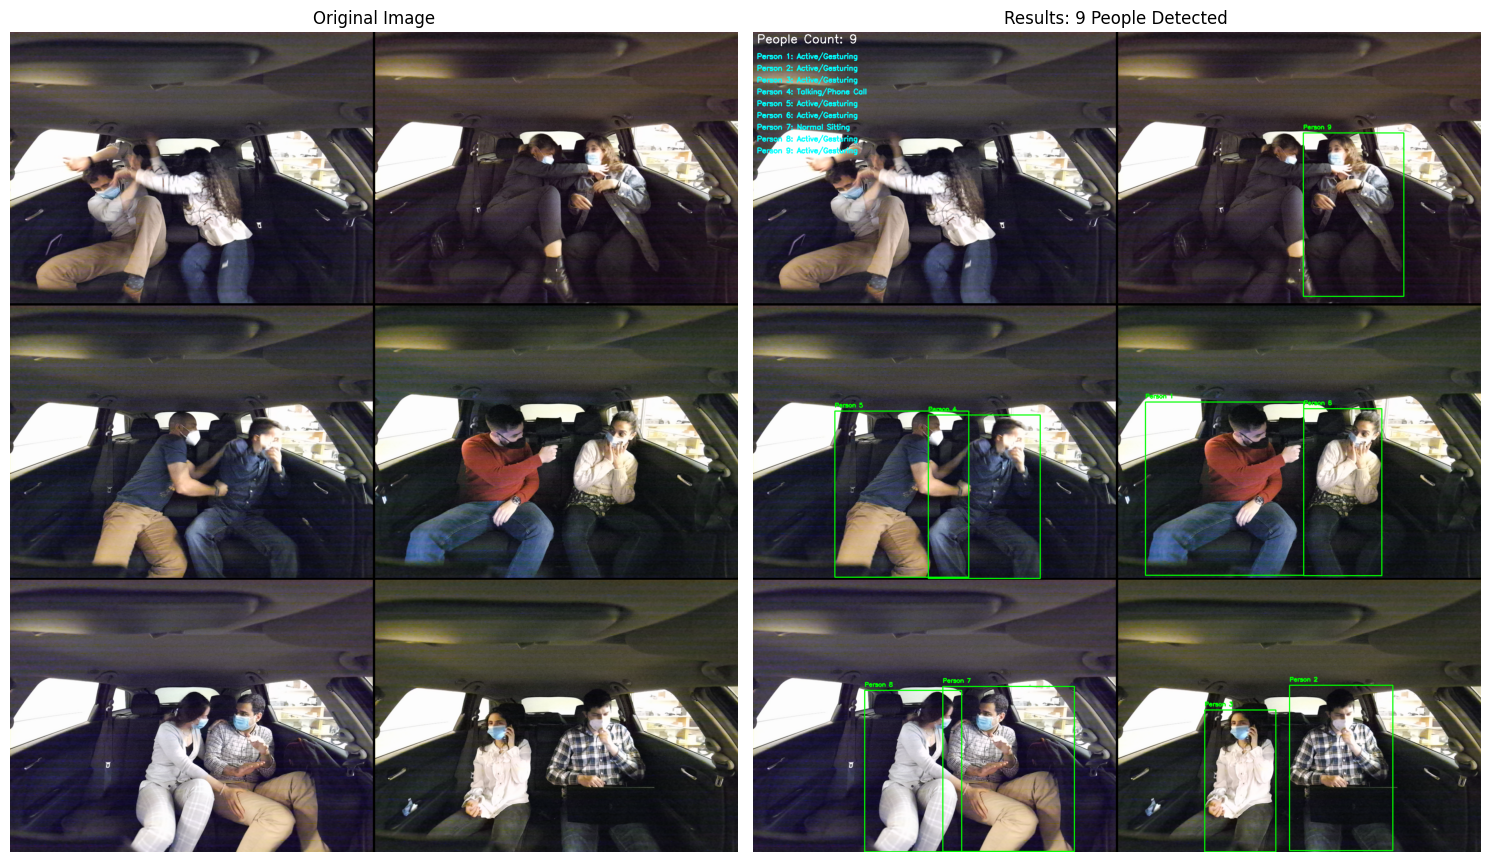


=== ANALYSIS RESULTS ===
Number of people detected: 9
Activities detected:
  - Person 1: Active/Gesturing
  - Person 2: Active/Gesturing
  - Person 3: Active/Gesturing
  - Person 4: Talking/Phone Call
  - Person 5: Active/Gesturing
  - Person 6: Active/Gesturing
  - Person 7: Normal Sitting
  - Person 8: Active/Gesturing
  - Person 9: Active/Gesturing
Output saved as output_dataset.png


In [6]:
# Upload images from your device
print("Upload images to test the system:")
uploaded = files.upload()

# Process each uploaded image
for filename in uploaded.keys():
    print(f"\nProcessing {filename}...")
    output_frame = process_image(filename)

    # Save the output
    output_filename = f"output_{filename}"
    cv2.imwrite(output_filename, output_frame)
    print(f"Output saved as {output_filename}")


Running sample test...
Sample image created: sample_car_interior.jpg

0: 480x640 (no detections), 177.4ms
Speed: 3.1ms preprocess, 177.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


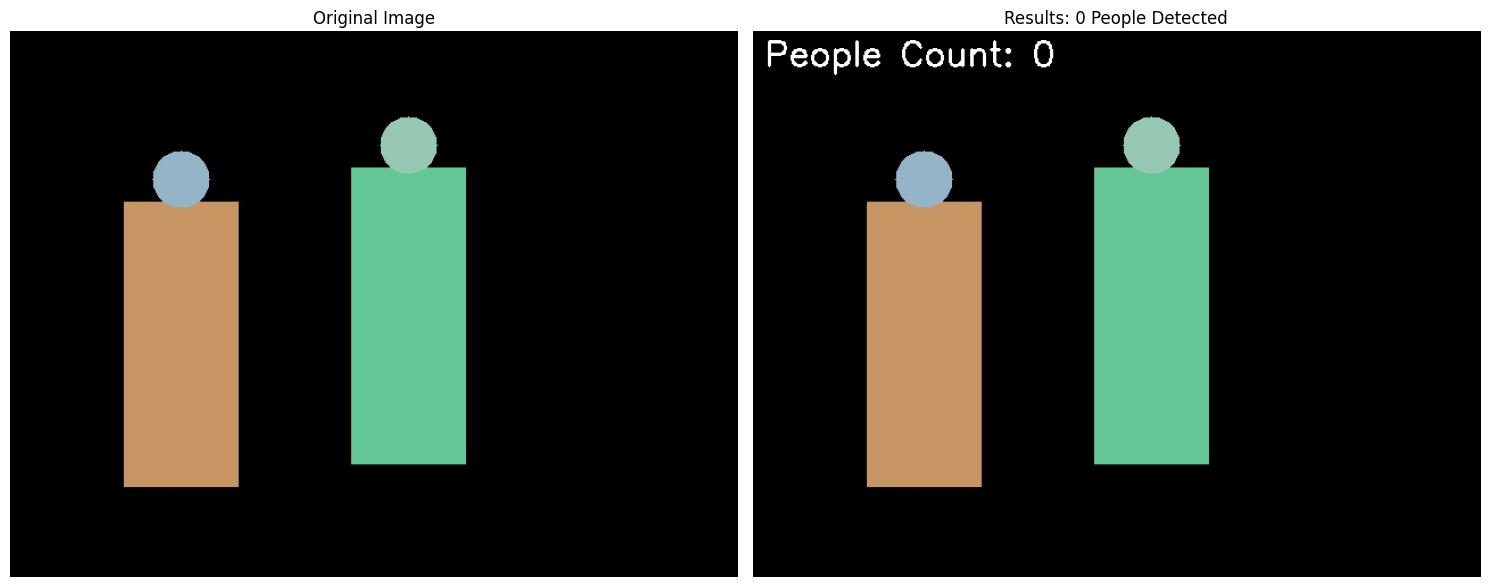


=== ANALYSIS RESULTS ===
Number of people detected: 0
Activities detected:


In [7]:
# Create a sample test with a dummy image
def create_sample_test():
    """Create a sample test image with people-like shapes"""
    # Create a blank image
    img = np.zeros((480, 640, 3), dtype=np.uint8)

    # Add some colored rectangles to simulate people
    cv2.rectangle(img, (100, 150), (200, 400), (100, 150, 200), -1)  # Person 1
    cv2.rectangle(img, (300, 120), (400, 380), (150, 200, 100), -1)  # Person 2

    # Add some circles for heads
    cv2.circle(img, (150, 130), 25, (200, 180, 150), -1)  # Head 1
    cv2.circle(img, (350, 100), 25, (180, 200, 150), -1)  # Head 2

    # Save sample image
    cv2.imwrite('sample_car_interior.jpg', img)
    print("Sample image created: sample_car_interior.jpg")

    # Process the sample
    return process_image('sample_car_interior.jpg')

# Run sample test
print("Running sample test...")
sample_output = create_sample_test()


In [8]:
def generate_report(people_count, activities, timestamp=None):
    """Generate a detailed report of the analysis"""
    if timestamp is None:
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    report = f"""
=== IN-CABIN MONITORING REPORT ===
Timestamp: {timestamp}
People Count: {people_count}

Activity Analysis:
"""
    for activity in activities:
        report += f"  • {activity}\n"

    # Safety assessment
    if people_count == 0:
        safety_status = "⚠️  WARNING: No driver detected"
    elif people_count == 1:
        safety_status = "✅ NORMAL: Single occupant detected"
    elif people_count <= 4:
        safety_status = f"✅ NORMAL: {people_count} occupants detected"
    else:
        safety_status = f"⚠️  ALERT: High occupancy ({people_count} people)"

    report += f"\nSafety Status: {safety_status}\n"
    report += "=" * 40

    print(report)
    return report

def save_analysis_results(output_frame, report, filename="analysis_results"):
    """Save both image and report"""
    # Save image
    cv2.imwrite(f'{filename}.jpg', output_frame)

    # Save report
    with open(f'{filename}_report.txt', 'w') as f:
        f.write(report)

    print(f"Results saved as {filename}.jpg and {filename}_report.txt")

# Example usage with reporting
def complete_analysis(image_path):
    """Complete analysis with reporting"""
    frame = cv2.imread(image_path)
    if frame is None:
        print("Error: Could not load image")
        return

    # Perform analysis
    people_count, person_boxes = monitor.detect_people_count(frame)
    activities = monitor.recognize_activity(frame, person_boxes)
    output_frame = monitor.draw_results(frame, people_count, person_boxes, activities)

    # Generate report
    report = generate_report(people_count, activities)

    # Save results
    save_analysis_results(output_frame, report, "cabin_analysis")

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
    plt.title('In-Cabin Monitoring Results')
    plt.axis('off')
    plt.show()

    return output_frame, report
